# Loading Previous Solve

Code demonstrating how to load existing data from previous solve stored in a model state dataframe.

A heat model loaded state will contain the following:

    1. Observation data frame = '/data'
    2. Samples data frame = '/samples'

If results from an online solve have been added to the 

    3. Full results from online solves = '/online_results':

        a. Column with metrics such as e_r, kl, MUD point, predict delta
        b. Columns identifying solve params used = pca_mask, pca_components, etc.
        c. Columns identifying decisions made - closest, max_kl, etc.
        d. Rows are expanded over all solves tried and all sub-iterations within each of those solves tried in each iteration
    4. States from online skolve = '/full_state'
        a. Columns 

In [1]:
from pydci.examples.heat_model import HeatModel
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import importlib

from pydci import OnlineSequential
from pydci.log import enable_log, disable_log
from pydci.utils import get_df, set_seed

# Create initial condition
def initial_condition(x, a=5):
    return np.exp(-a * (x[0] ** 2 + x[1] ** 2))

class ForcingFunction:
    def __init__(self):
        self.t = 0.0

    def eval(self, x):
        # Added some spatial variation here. Expression is sin(t)*x
        return np.full(
            x.shape[1],
            (10*np.sin(6 * np.pi * self.t) * x[0]
            + 10*np.cos(4 * np.pi * self.t) * x[1]),
        )

num_modes = 10
set_seed(2023)
# enable_log(level="DEBUG")
heat_model_args = dict(
    x0=initial_condition,
    measurement_noise=0.05,
    solve_ts=0.0001,
    sample_ts=0.05,
    nx=50,
    ny=50,
    mean=1.0,
    std_dev=0.2,
    length_scales=[0.1, 0.1],
    nmodes=num_modes,
    true_k_x=None,
    max_states=500,
    forcing_expression=ForcingFunction(),
)

In [2]:
load_args = heat_model_args.copy()
load_args['model_file'] = 'hm_patched.h5'  # 'hm_10_solution.h5'
hm = HeatModel(**load_args)
hm.lam_true

array([ 0.71167353, -0.32448496, -1.00187064,  0.23625079, -0.10215984,
       -1.14129263,  2.65440726,  1.44060519,  0.09890227, -3.12153215])

## Getting Mud Points

In [3]:
# Get mud points by selecting on best-flag for each iteration
mud_points = get_df(hm.full_state[hm.full_state['best_flag']], 'lam', 10)
mud_points

array([[-1.2578153 ,  1.29301839,  0.56076192,  1.70677136, -1.01404776,
        -0.09504395,  0.11079022,  1.29384539, -1.18240041, -1.07460397],
       [ 0.422582  ,  0.95141407,  1.14838444,  0.66373292, -0.29191958,
        -2.76098218, -0.2694898 , -0.32313561, -1.30255129,  0.39066624],
       [-0.83582282, -0.27782625,  1.04626011,  0.4481414 , -2.12470265,
        -1.88217308,  0.36297854,  0.18699019, -0.8063186 , -0.99645604],
       [-0.02266669,  0.80536657, -1.15574128,  0.70759766, -0.41551672,
        -0.30695754,  1.9458895 ,  0.85345341, -0.97345448, -3.80570187],
       [ 1.31725505,  1.34449396, -2.55347353,  0.06023831,  0.00562459,
         0.14459656,  1.37206363,  1.49327109, -1.1001423 , -4.05760472],
       [ 0.02286624, -0.91774953, -0.07302506,  0.7809766 , -1.16005314,
        -0.53266264,  2.9315858 ,  0.83193547, -0.69441845, -4.1986497 ]])

In [4]:
# Calculating Error for a given iteration
true_field = hm.process_field(hm.lam_true)
mud_field = hm.process_field(mud_points[0])
err = np.linalg.norm(np.abs(mud_field - true_field))/np.linalg.norm(true_field)
err

0.060364925493943795

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
hm.plot_field(ax=ax, vmin=0.8, vmax=1.2)

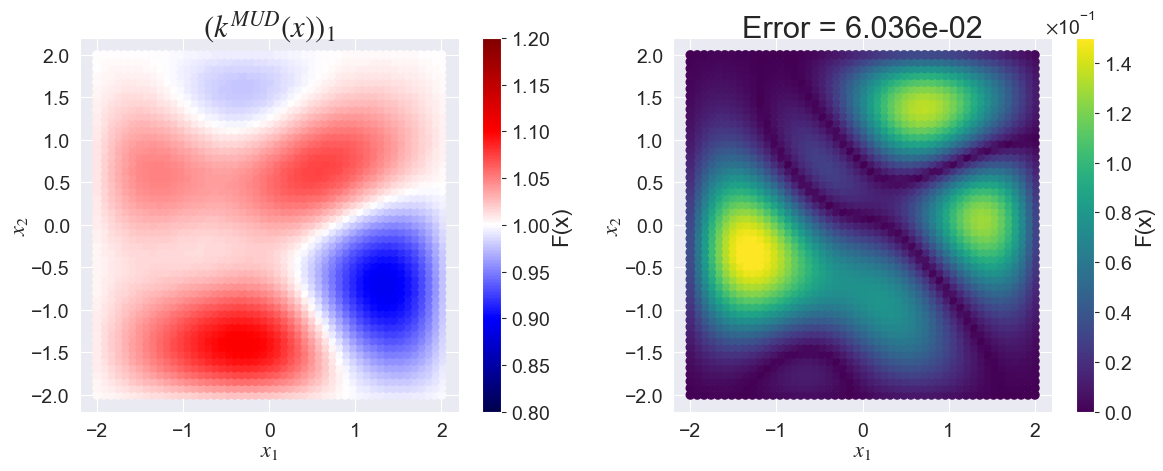

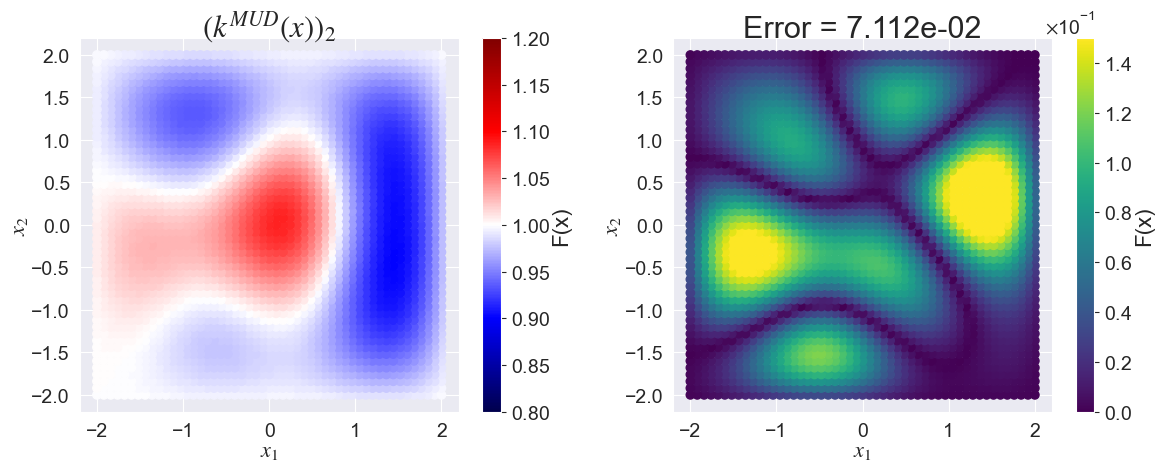

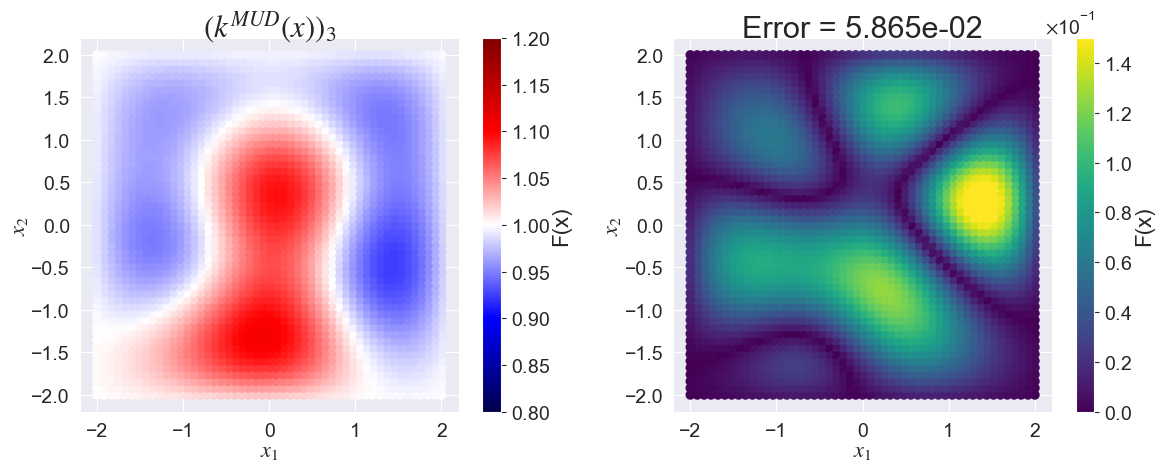

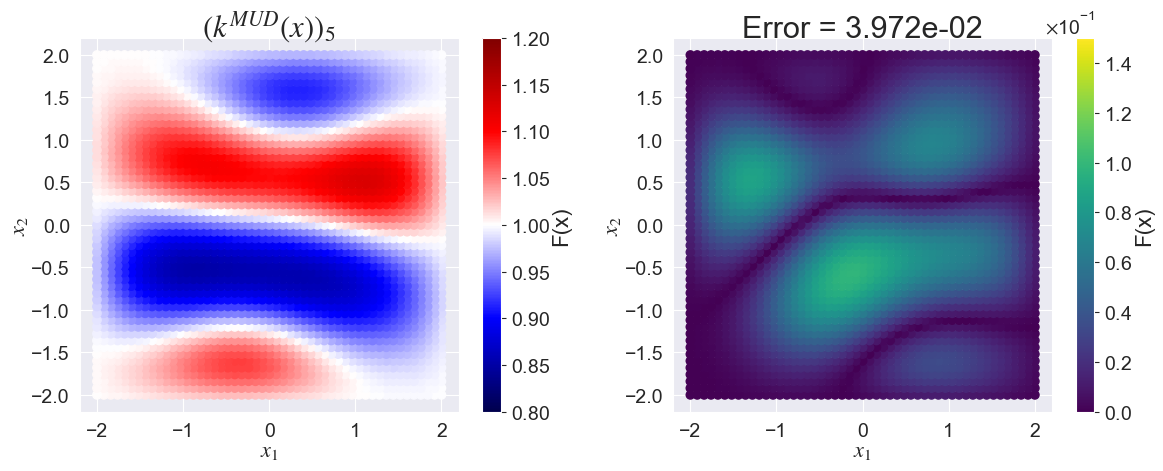

In [6]:
# Look into the plot_field method for more customization.
for i, mp in enumerate(mud_points):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    true_field = hm.process_field(hm.lam_true)
    mud_field = hm.process_field(mp)
    err = np.linalg.norm(np.abs(mud_field - true_field))/np.linalg.norm(true_field)

    hm.plot_field(field=mud_field, ax=ax[0], vmin=0.8, vmax=1.2)
    ax[0].set_title(f"$(k^{{MUD}}(x))_{i+1}$")
    hm.plot_field(diff=mud_field, ax=ax[1], relative_error=True, vmin=0, vmax=0.15)
    ax[1].set_title(f'Error = {err:.3e}')
    # ax[1].set_title(f'$||(k^\\mathrm{{MUD}}(x)) - k^\\dagger(x)||/||k^\\dagger(x)||$ = {err:.3e}', fontsize=12)
    plt.tight_layout()


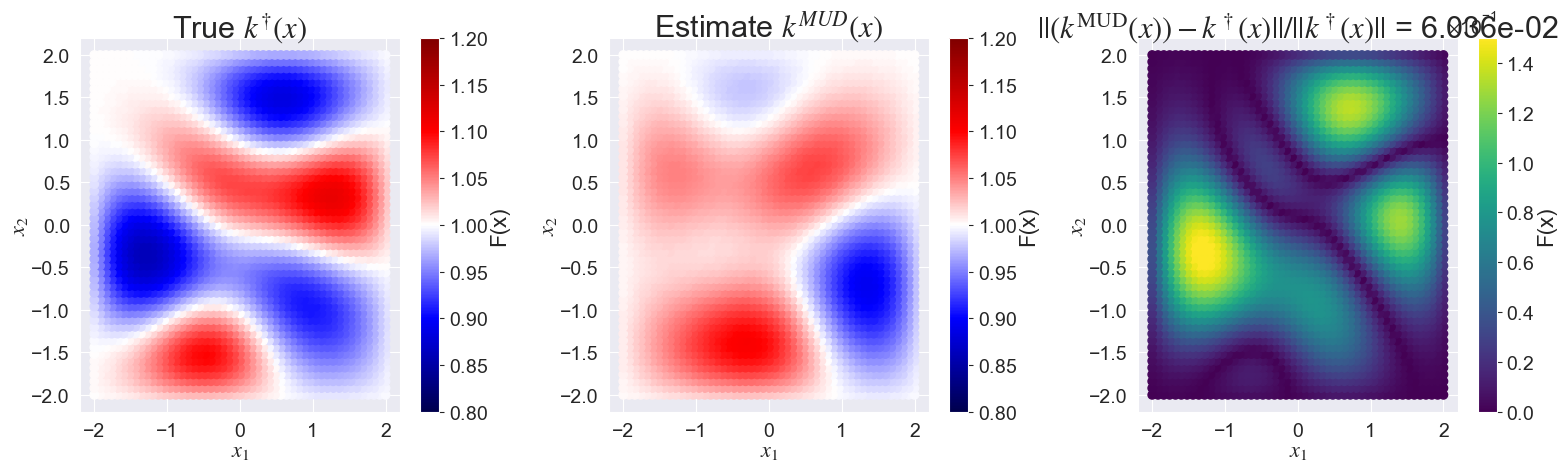

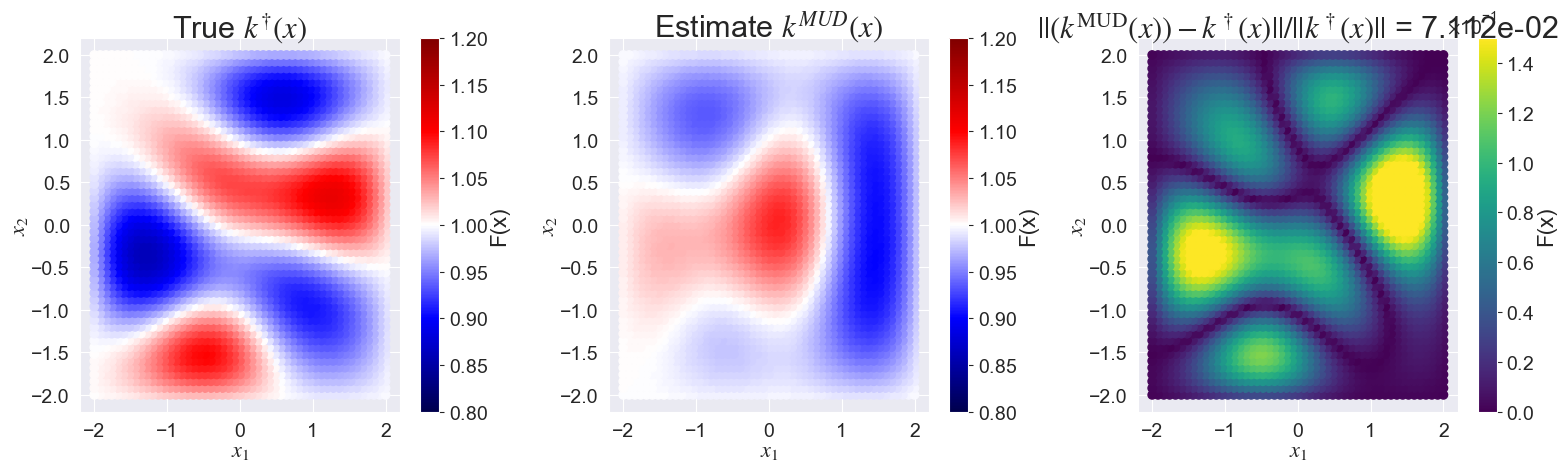

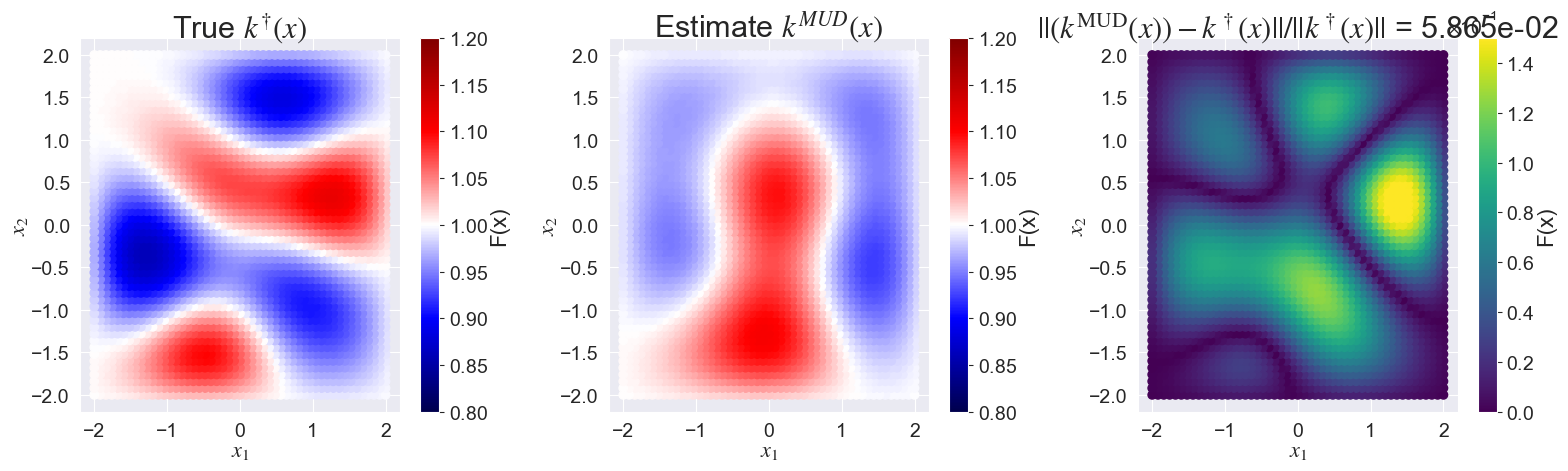

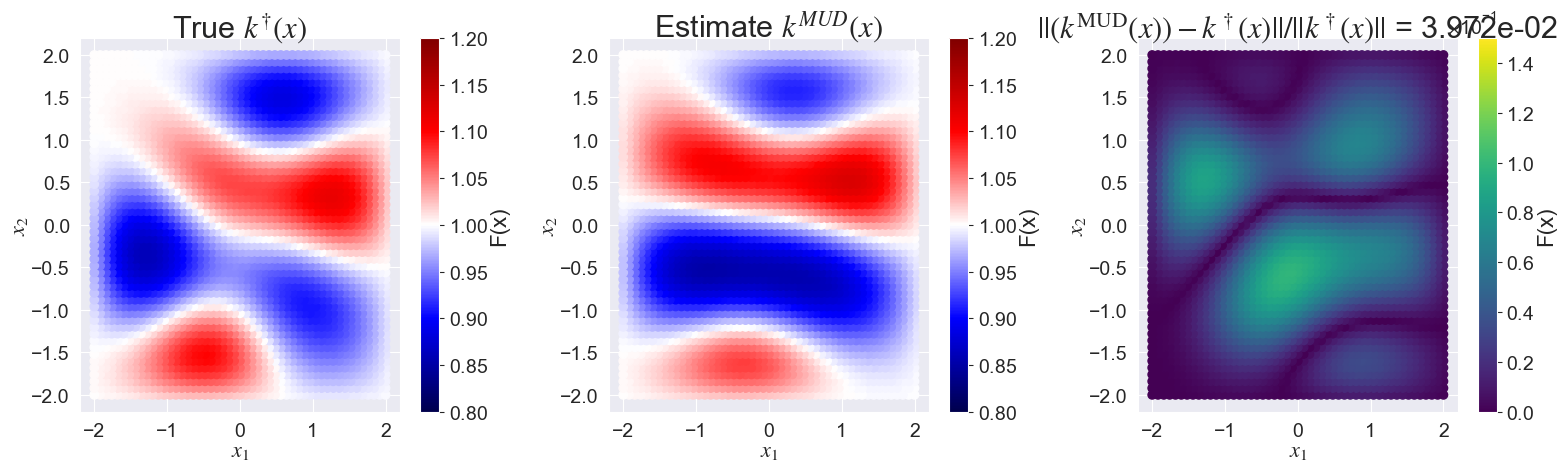

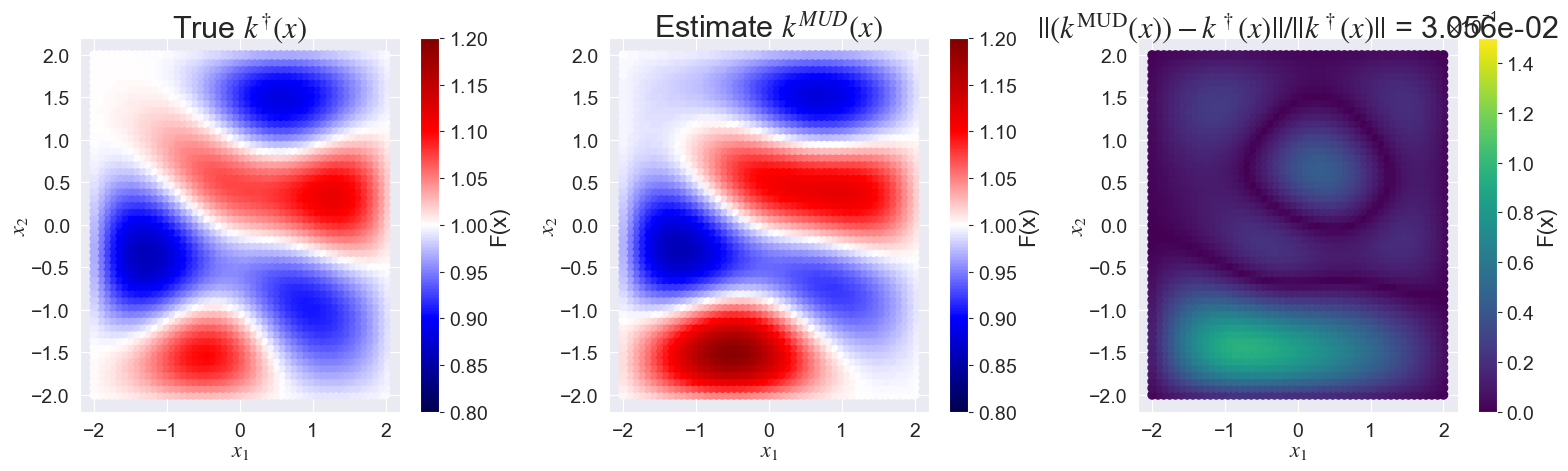

In [7]:
for i, mp in enumerate(mud_points):
    fig, ax = plt.subplots(1, 3, figsize=(16, 5))

    hm.plot_field(ax=ax[0], vmin=0.8, vmax=1.2)
    ax[0].set_title("True $k^{\dagger}(x)$")
    hm.plot_field(field=mp, ax=ax[1], vmin=0.8, vmax=1.2)
    ax[1].set_title("Estimate $k^{MUD}(x)$")
    hm.plot_field(diff=mp, ax=ax[2], relative_error=True, vmin=0, vmax=0.15)
    # fig.suptitle(f'Iteration {i + 1}')

    fig.tight_layout()

## Analyzing Results From Solves

Looking at online_results dataframe storing solve information that produced the previous estimates

In [8]:
hm.online_results

e_r        kl  k_eff  k_eff_up  solved  \
0 0  1.058571  1.819975   1.00      0.65    True   
  0  0.741669  2.787553   1.00      0.81   False   
  0  0.891363  1.802259   1.00      0.91    True   
  0  0.915711  0.949225   0.91      0.72    True   
  0  1.067550  0.254806   0.72      0.68    True   
..        ...       ...    ...       ...     ...   
5 0  0.906179  0.138338   1.00      1.00    True   
  0  0.688088  2.317976   1.00      1.00   False   
  0  1.048815  0.217030   1.00      1.00    True   
  0  0.889936  0.355984   1.00      1.00    True   
  0  0.704668  1.523764   1.00      1.00   False   

                                                 error  lam_MUD_0  lam_MUD_1  \
0 0                                               None  -1.257815   1.293018   
  0  Failed to solve problem on iteration 1 - |E(r)...  -1.257815   1.293018   
  0                                               None  -1.257815   1.293018   
  0                                               None   0.520605   2.861975   
  0                                               None   0.520605   2.861975   
..                                                 ...        ...        ...   
5 0                                               None   1.700560   0.262562   
  0  Failed to solve problem on iteration 3 - |E(r)...   0.624944   0.011813   
  0                                               None   1.650941   0.760034   
  0                                               None   1.673601   1.583177   
  0  Failed to solve problem on iteration 3 - |E(r)...   1.882638   0.372196   

     lam_MUD_2  lam_MUD_3  ...           pca_mask  i  I  search_index  \
0 0   0.560762   1.706771  ...     range(0, 5500)  1  1             0   
  0   0.560762   1.706771  ...     range(0, 2750)  1  2             1   
  0   0.560762   1.706771  ...     range(0, 1834)  1  3             2   
  0  -0.484331   1.088259  ...  range(1834, 3667)  2  3             2   
  0  -0.484331   1.088259  ...  range(3667, 5500)  3  3             2   
..         ...        ...  ...                ... .. ..           ...   
5 0  -0.992670   0.367841  ...   range(688, 1376)  2  8            16   
  0  -0.698808   1.489576  ...  range(1376, 2064)  3  8            16   
  0  -2.007252   0.435868  ...      range(0, 612)  1  9            17   
  0  -2.383394   0.608304  ...   range(612, 1223)  2  9            17   
  0  -0.175796   1.138807  ...  range(1223, 1834)  3  9            17   

     predict_delta  within_thresh  valid closest max_kl  min_kl  
0 0       0.058571           True   True   False  False   False  
  0       0.258331           True  False   False  False   False  
  0       0.108637           True   True   False  False   False  
  0       0.084289           True   True   False  False   False  
  0       0.067550           True   True   False  False   False  
..             ...            ...    ...     ...    ...     ...  
5 0       0.093821           True   True   False  False   False  
  0       0.311912           True  False   False  False   False  
  0       0.048815           True   True   False  False   False  
  0       0.110064           True   True   False  False   False  
  0       0.295332           True  False   False  False   False  

[309 rows x 28 columns]

In [9]:
result_groups = hm.online_results.groupby(level=0)

first_iteration_results = result_groups.get_group('0').dropna(axis=1)
first_iteration_results

e_r        kl  k_eff  k_eff_up  solved  lam_MUD_0  lam_MUD_1  \
0 0  1.058571  1.819975   1.00      0.65    True  -1.257815   1.293018   
  0  0.741669  2.787553   1.00      0.81   False  -1.257815   1.293018   
  0  0.891363  1.802259   1.00      0.91    True  -1.257815   1.293018   
  0  0.915711  0.949225   0.91      0.72    True   0.520605   2.861975   
  0  1.067550  0.254806   0.72      0.68    True   0.520605   2.861975   
  0  0.925159  1.176285   1.00      1.00    True  -1.257815   1.293018   
  0  0.926401  1.163498   1.00      0.91    True   0.520605   2.861975   
  0  1.067679  0.369135   0.91      0.76    True   0.520605   2.861975   
  0  1.086870  0.178547   0.76      0.74    True   0.520605   2.861975   
  0  0.946910  0.821352   1.00      1.00    True   1.215957  -0.418266   
  0  0.833390  1.239338   1.00      0.98    True  -1.257815   1.293018   
  0  1.104490  0.847416   0.98      0.76    True   0.520605   2.861975   
  0  0.836047  2.101730   0.76      0.60    True  -0.250845   0.664744   
  0  0.407932  1.515412   0.60      0.57   False   0.538543   0.872553   
  0  0.969193  0.358842   1.00      1.00    True   1.215957  -0.418266   
  0  0.743551  1.387061   1.00      0.96   False   0.520605   2.861975   
  0  0.929733  0.502097   1.00      1.00    True  -0.118708  -0.092447   
  0  0.935297  0.342006   1.00      1.00    True   0.520605   2.861975   
  0  0.999891  0.609852   1.00      0.94    True   0.520605   2.861975   
  0  0.944928  0.434255   0.94      0.89    True   0.520605   2.861975   
  0  1.075231  0.413796   0.89      0.73    True   0.520605   2.861975   
  0  0.323549  6.303217   0.73      0.81   False  -1.257815   1.293018   
  0  0.910382  0.589079   1.00      1.00    True  -0.701728  -0.921893   
  0  0.924530  0.741427   1.00      1.00    True  -0.470832   0.730065   
  0  1.059689  0.187413   1.00      1.00    True  -0.470832   0.730065   
  0  1.150689  0.291627   1.00      1.00    True  -0.470832   0.730065   
  0  0.994455  0.645423   1.00      0.96    True   1.219365   0.909631   
  0  1.166344  0.107745   0.96      0.94    True   1.219365   0.909631   
  0  0.826423  0.420271   0.94      0.94    True   1.219365   0.909631   
  0  1.038419  0.098608   0.94      0.91    True   2.813573  -0.691082   
  0  0.938038  1.097128   1.00      1.00    True  -0.701728  -0.921893   
  0  0.606441  1.080044   1.00      1.00   False  -1.172039  -1.930413   
  0  0.531540  2.930697   1.00      0.49   False  -0.433753   0.375229   
  0  0.907477  3.607680   1.00      0.74    True  -1.257815   1.293018   
  0  0.133885  3.582062   0.74      0.54   False   2.813573  -0.691082   
  0  0.581499  2.833744   1.00      0.89   False  -1.257815   1.293018   
  0  0.835458  1.375515   1.00      1.00    True  -1.257815   1.293018   
  0  1.423419  1.466361   1.00      0.78   False  -1.257815   1.293018   
  0  0.738368  1.008217   1.00      1.00   False  -1.257815   1.293018   
  0  0.959933  0.608160   1.00      1.00    True  -0.118708  -0.092447   
  0  0.569833  1.514981   1.00      0.93   False   0.520605   2.861975   
  0  0.885967  0.699972   1.00      1.00    True  -0.118708  -0.092447   
  0  0.810565  0.308255   1.00      1.00    True   0.520605   2.861975   
  0  1.161882  1.078889   1.00      0.83    True   0.520605   2.861975   
  0  0.740042  0.635037   0.83      0.71   False   0.520605   2.861975   
  0  0.726745  1.280002   1.00      1.00   False  -0.701728  -0.921893   
  0  0.668618  1.608837   1.00      1.00   False  -1.255113  -1.584559   

     lam_MUD_2  lam_MUD_3  lam_MUD_4  ...           pca_mask  i  I  \
0 0   0.560762   1.706771  -1.014048  ...     range(0, 5500)  1  1   
  0   0.560762   1.706771  -1.014048  ...     range(0, 2750)  1  2   
  0   0.560762   1.706771  -1.014048  ...     range(0, 1834)  1  3   
  0  -0.484331   1.088259   0.995254  ...  range(1834, 3667)  2  3   
  0  -0.484331   1.088259   0.995254  ...  range(3667, 5500)  3  3   
  0   0.560762   1.706771  -1.014048 

### Results for first iteration

In [10]:
# Group by first index and drop first index
groups = hm.full_state.groupby(level=0)
iteration_keys = list(groups.groups.keys())

first_iteration = groups.get_group(iteration_keys[0]).dropna(axis=1)
first_iteration

lam_0     lam_1     lam_2     lam_3     lam_4     lam_5     lam_6  \
0 0   0.902777  0.980490  1.600040 -1.830969  0.905675 -2.043585 -0.850246   
  1  -0.118708 -0.092447  0.693102 -0.288900 -0.056751  0.784476 -1.042492   
  2  -1.294691  0.000800 -2.394093 -0.440840 -0.237559  0.104299 -0.090466   
  3  -0.224987 -0.318096 -0.114412  1.292431  0.792476  1.848870 -0.956733   
  4  -0.805359  1.672560 -1.928774  1.836009 -0.334832  0.976135  0.574535   
...        ...       ...       ...       ...       ...       ...       ...   
  95 -0.601078 -0.141784  0.716093  0.774008  0.065617 -2.722048  1.699861   
  96  0.163415 -3.468685 -0.071683  3.498933  0.826466 -0.800340  0.764395   
  97 -0.564534 -1.643817 -1.993708 -1.581846  1.368082  0.193401  0.073284   
  98 -0.776160  1.469089 -0.504098 -0.379016 -0.710480  0.980573  0.200408   
  99  1.881666  0.879781 -3.007947 -0.861911 -0.466217 -0.912456  0.015027   

         lam_7     lam_8     lam_9  ...  q_pca_2_search_17_0_state_1  \
0 0   1.455357  0.260101 -1.082954  ...                     1.414315   
  1   0.110872 -0.012422 -0.726591  ...                    -1.176399   
  2  -1.356193  0.605829  0.617137  ...                     1.165209   
  3   1.939115  0.209058 -0.523991  ...                     1.614925   
  4   2.736033 -3.332697 -0.728043  ...                    -0.295538   
...        ...       ...       ...  ...                          ...   
  95 -1.510429  3.101089  1.088682  ...                     4.657975   
  96  0.352711 -0.896988 -1.423302  ...                     1.071535   
  97 -2.233457  1.246827  3.466881  ...                     3.116910   
  98  1.678354 -0.754790  1.595896  ...                     3.683188   
  99 -0.856783 -0.396979  1.647677  ...                     3.664666   

      q_pca_3_search_17_0_state_1  q_pca_4_search_17_0_state_1  \
0 0                     -1.168381                    -1.166136   
  1                      0.216239                    -1.147669   
  2                     -1.075909                    -0.622179   
  3                     -0.467221                    -1.433581   
  4                      0.958716                     0.188819   
...                           ...                          ...   
  95                    -1.218615                    -1.959121   
  96                    -0.459323                    -3.065509   
  97                    -4.418791                     2.921004   
  98                     0.562729                     0.589654   
  99                    -1.525821                     1.439976   

      q_pca_5_search_17_0_state_1  q_pca_6_search_17_0_state_1  \
0 0                      3.444006                    -3.304959   
  1                     -1.004209                    -0.094557   
  2                      2.550936                     6.483663   
  3                     -0.921281                     5.565190   
  4                      0.898681                     2.380235   
...                           ...                          ...   
  95                     4.013775                    -4.858840   
  96                    -3.654599                    -2.004900   
  97                    -6.102740                    -1.941670   
  98                    -1.247529                    -1.841659   
  99                    -1.238471                     1.321651   

      q_pca_7_search_17_0_state_1  q_pca_8_search_17_0_state_1  \
0 0                      2.760040                     6.318839   
  1                     -5.074537                    -0.314121   
  2                     -1.516674                     1.641120   
  3                     -0.436510                    -1.557123   
  4                      2.370772                    -2.995858   
...                           ...                          ...   
  95                    -0.909780                    -1.886436   
  96                    -4.917521                    -1.973253   
  97                    -0.

## Recreating Density Plots

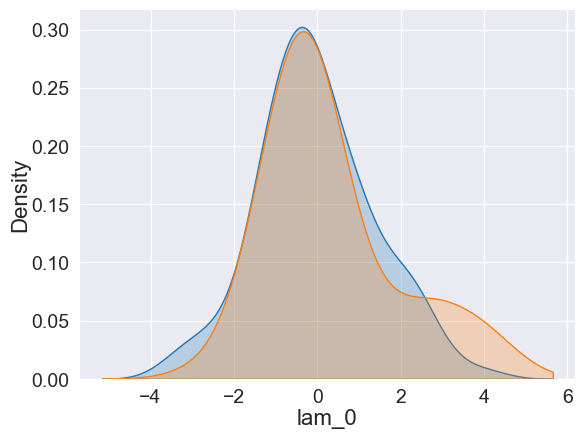

In [11]:
import seaborn as sns
ax = sns.kdeplot(
    data=first_iteration,
    x='lam_0',
    fill=True,
)
ax = sns.kdeplot(
    data=first_iteration,
    x='lam_0',
    fill=True,
    weights='weighted_ratio_best_0',
    ax=ax,
)

In [12]:
[c for c in first_iteration.columns if c.startswith('best')]

['best_flag']

Text(0.5, 1.0, 'First Iteration, Search Index 7 Results')

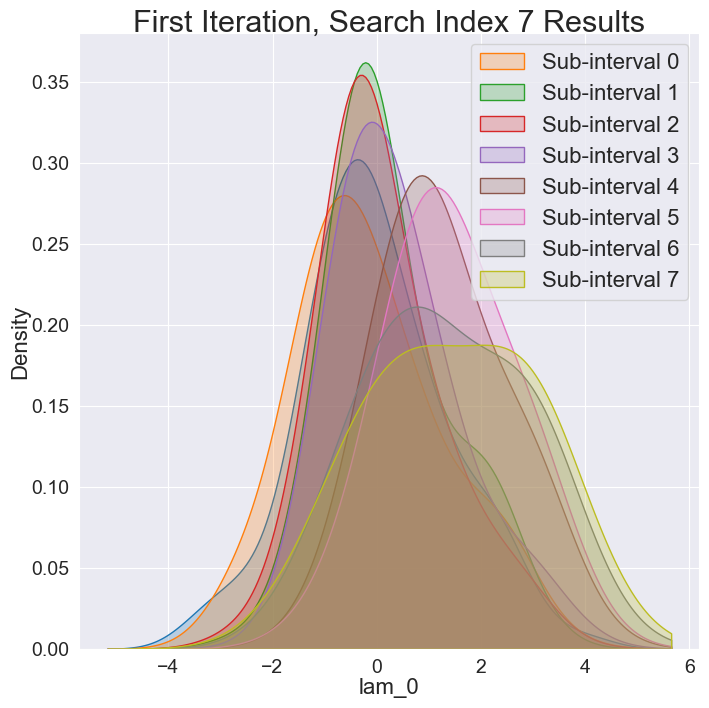

In [13]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 8))

search_7 = [c for c in first_iteration.columns if c.startswith('weighted_ratio_search_7_0_state')]

ax = sns.kdeplot(
    data=first_iteration,
    x='lam_0',
    fill=True,
)

for i, c in enumerate(search_7):
    ax = sns.kdeplot(
        data=first_iteration,
        x='lam_0',
        fill=True,
        weights=c,
        ax=ax,
        label=f'Sub-interval {i}'
    )

ax.legend()
ax.set_title('First Iteration, Search Index 7 Results')

In [14]:
first_iteration_results[first_iteration_results['search_index'] == 7]

e_r        kl  k_eff  k_eff_up  solved  lam_MUD_0  lam_MUD_1  \
0 0  0.910382  0.589079   1.00      1.00    True  -0.701728  -0.921893   
  0  0.924530  0.741427   1.00      1.00    True  -0.470832   0.730065   
  0  1.059689  0.187413   1.00      1.00    True  -0.470832   0.730065   
  0  1.150689  0.291627   1.00      1.00    True  -0.470832   0.730065   
  0  0.994455  0.645423   1.00      0.96    True   1.219365   0.909631   
  0  1.166344  0.107745   0.96      0.94    True   1.219365   0.909631   
  0  0.826423  0.420271   0.94      0.94    True   1.219365   0.909631   
  0  1.038419  0.098608   0.94      0.91    True   2.813573  -0.691082   

     lam_MUD_2  lam_MUD_3  lam_MUD_4  ...           pca_mask  i  I  \
0 0  -0.605749  -1.245464   0.458492  ...      range(0, 688)  1  8   
  0  -0.362644   1.140120   0.034262  ...   range(688, 1376)  2  8   
  0  -0.362644   1.140120   0.034262  ...  range(1376, 2064)  3  8   
  0  -0.362644   1.140120   0.034262  ...  range(2064, 2752)  4  8   
  0  -1.032082  -1.143926   0.452347  ...  range(2752, 3439)  5  8   
  0  -1.032082  -1.143926   0.452347  ...  range(3439, 4126)  6  8   
  0  -1.032082  -1.143926   0.452347  ...  range(4126, 4813)  7  8   
  0   0.508374   0.557711   0.228500  ...  range(4813, 5500)  8  8   

     search_index  predict_delta  within_thresh valid closest  max_kl  min_kl  
0 0             7       0.089618           True  True   False   False   False  
  0             7       0.075470           True  True   False   False   False  
  0             7       0.059689           True  True   False   False   False  
  0             7       0.150689           True  True   False   False   False  
  0             7       0.005545           True  True   False   False   False  
  0             7       0.166344           True  True   False   False   False  
  0             7       0.173577           True  True   False   False   False  
  0             7       0.038419           True  True   False   False    True  

[8 rows x 27 columns]